In [4]:
base_dir = "/Users/arnavbhatnagar/Downloads/v_2"
categories = ['agri', 'barrenland', 'grassland', 'urban']

In [5]:
from PIL import Image
import os
import numpy as np

# Load and normalize color images
image_path_col = '/Users/arnavbhatnagar/Downloads/v_2/urban/s2'
color_images_files = [f for f in os.listdir(image_path_col) if f.endswith('.jpg') or f.endswith('.png')]
color_images = [Image.open(os.path.join(image_path_col, img_file)).convert("RGB") for img_file in color_images_files]
color_images = np.array([np.array(img) / 255.0 for img in color_images])  # Normalize to [0, 1]

# Load and normalize grayscale images
image_path_gray = '/Users/arnavbhatnagar/Downloads/v_2/urban/s1'
gray_images_file = [f for f in os.listdir(image_path_gray) if f.endswith('.jpg') or f.endswith('.png')]
gray_images = [Image.open(os.path.join(image_path_gray, img_file)).convert("L") for img_file in gray_images_file]
gray_images = np.array([np.array(img) / 255.0 for img in gray_images])  # Normalize to [0, 1]

In [6]:
import cv2
# Target size for resizing
target_size = (224, 224)  # New dimensions (width, height)

# Resize all images 
gray_images= np.array([cv2.resize(img, target_size) for img in gray_images])
color_images = np.array([cv2.resize(img,target_size) for img in color_images])
#converting 2d array to 3d array
gray_images = np.expand_dims(gray_images, axis=-1)


print(gray_images.shape)  # Output: (4000, 128, 128, 1)
print(color_images.shape)

(4000, 224, 224, 1)
(4000, 224, 224, 3)


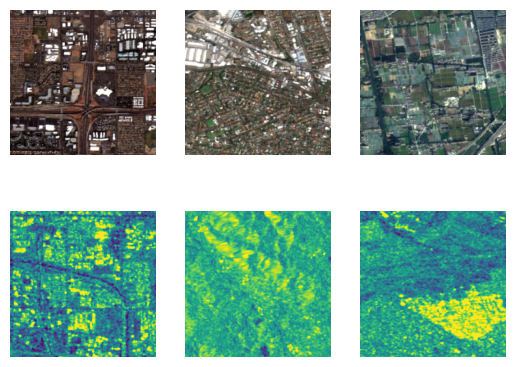

In [7]:
import matplotlib.pyplot as pyplot
n_samples = 3
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + i)
	pyplot.axis('off')
	pyplot.imshow(color_images[i])
# plot target image
for i in range(n_samples):
	pyplot.subplot(2, n_samples, 1 + n_samples + i)
	pyplot.axis('off')
	pyplot.imshow(gray_images[i])
pyplot.show()

In [8]:
data = [gray_images, color_images]

def preprocess_data(data):
	# load compressed arrays
	# unpack arrays
	X1, X2 = data[0], data[1]
	# scale from [0,255] to [-1,1]
	X1 = (X1 - 127.5) / 127.5
	X2 = (X2 - 127.5) / 127.5
	return [X1, X2]

dataset = preprocess_data(data)

In [9]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [10]:
def build_generator(image_shape):
    input_layer = Input(shape=image_shape)  # Input shape (height, width, channels)

    # Encoder
    e1 = Conv2D(64, (3, 3), padding='same', activation='relu')(input_layer)
    e2 = Conv2D(128, (3, 3), padding='same', activation='relu')(e1)
    e3 = Conv2D(128, (3, 3), padding='same', activation='relu')(e2)

    # Decoder
    d1 = Conv2DTranspose(128, (3, 3), padding='same', activation='relu')(e3)
    d2 = Conv2DTranspose(64, (3, 3), padding='same', activation='relu')(d1)
    output_layer = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(d2)  # Output color image

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [11]:
def build_discriminator(image_shape):
    input_layer = Input(shape=image_shape)

    x = Conv2D(64, (3, 3), strides=2, padding='same', activation='relu')(input_layer)
    x = Dropout(0.3)(x)
    x = Conv2D(128, (3, 3), strides=2, padding='same', activation='relu')(x)
    x = Dropout(0.3)(x)
    x = Flatten()(x)
    output_layer = Dense(1, activation='sigmoid')(x)  # Output probability of being real

    model = Model(inputs=input_layer, outputs=output_layer)
    return model

In [12]:
def build_gan(generator, discriminator):
    discriminator.trainable = False  # Freeze the discriminator during GAN training

    input_layer = Input(shape=(None, None, 1))  # Grayscale input
    generated_image = generator(input_layer)
    validity = discriminator(generated_image)

    model = Model(inputs=input_layer, outputs=[generated_image, validity])
    return model

In [13]:
# Define image shape
image_shape = (224, 224, 1)  # Grayscale images

# Build models
generator = build_generator(image_shape)
discriminator = build_discriminator((224, 224, 3))  # Color images
gan = build_gan(generator, discriminator)

# Compile models
optimizer = Adam(learning_rate=0.0002, beta_1=0.5)

discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
gan.compile(loss='binary_crossentropy', optimizer=optimizer)

In [14]:
def train_gan(gan, generator, discriminator, epochs, batch_size, grayscale_images, color_images):
    for epoch in range(epochs):
        # Select a random batch of images
        idx = np.random.randint(0, grayscale_images.shape[0], batch_size)
        grayscale_batch = grayscale_images[idx]
        color_batch = color_images[idx]

        # Generate fake color images
        generated_images = generator.predict(grayscale_batch)

        # Create labels for real and fake images
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))

        # Train the discriminator
        d_loss_real = discriminator.train_on_batch(color_batch, real_labels)
        d_loss_fake = discriminator.train_on_batch(generated_images, fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the generator
        g_loss = gan.train_on_batch(grayscale_batch, [color_batch, real_labels])
          # Print the progress
        if epoch % 100 == 0:
            print(f"{epoch} [D loss: {d_loss[0]:.4f}, acc.: {100 * d_loss[1]:.2f}%] [G loss: {g_loss[0]:.4f}]")

In [15]:
# Assuming `grayscale_images` and `color_images` are your datasets
train_gan(gan, generator, discriminator, epochs=20, batch_size=1, grayscale_images=gray_images, color_images=color_images)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/keras/src/backend/tensorflow/trainer.py:75: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


0 [D loss: 0.6206, acc.: 100.00%] [G loss: 0.6263]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step


In [16]:
import numpy as np
from skimage.metrics import mean_squared_error, structural_similarity as ssim

def calculate_metrics(generator, grayscale_images, color_images):
    # Generate color images from the grayscale input
    generated_images = generator.predict(grayscale_images)
    
    mse_values = []
    ssim_values = []
    
    for i in range(len(generated_images)):
        original = color_images[i]
        generated = generated_images[i]
        
        # Compute MSE between the generated and original color images
        mse = mean_squared_error(original, generated)
        mse_values.append(mse)
        
        # Compute SSIM between the generated and original color images
        ssim_value = ssim(original, generated, win_size=3, data_range=1.0, channel_axis=-1)
        ssim_values.append(ssim_value)
    
    avg_mse = np.mean(mse_values)
    avg_ssim = np.mean(ssim_values)
    
    return avg_mse, avg_ssim

# Example usage:
# Assuming `generator` is your trained generator model,
# and `gray_images` and `color_images` are your datasets.

avg_mse, avg_ssim = calculate_metrics(generator, gray_images[:100], color_images[:100])

print(f"Average MSE: {avg_mse:.4f}")
print(f"Average SSIM: {avg_ssim:.4f}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step
Average MSE: 0.0433
Average SSIM: 0.2443


In [17]:
#try

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step


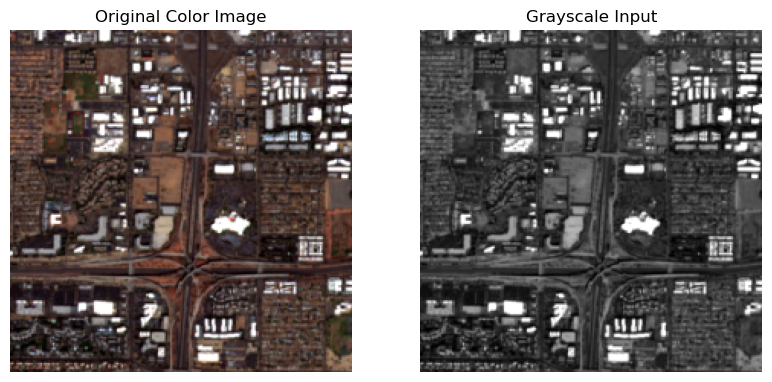

In [18]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_single_prediction(generator, original_color_image):
    # Convert the original color image to uint8 type
    original_color_image = (original_color_image * 255).astype(np.uint8)
    
    # Convert the original color image to grayscale
    grayscale_image = cv2.cvtColor(original_color_image, cv2.COLOR_RGB2GRAY)
    grayscale_image = cv2.resize(grayscale_image, (224, 224))  # Resize to match input size
    grayscale_image = grayscale_image / 255.0  # Normalize to [0, 1]
    grayscale_image = np.expand_dims(grayscale_image, axis=-1)  # Add channel dimension
    grayscale_image = np.expand_dims(grayscale_image, axis=0)  # Add batch dimension

    # Generate colorized image
    colorized_image = generator.predict(grayscale_image)
    colorized_image = np.squeeze(colorized_image, axis=0)  # Remove batch dimension
    colorized_image = np.clip(colorized_image, 0, 1)  # Ensure values are in the range [0, 1]

    # Display the images
    plt.figure(figsize=(15, 5))

    # Original color image
    plt.subplot(1, 3, 1)
    plt.imshow(cv2.resize(original_color_image, (224, 224)))
    plt.title('Original Color Image')
    plt.axis('off')

    # Grayscale image
    plt.subplot(1, 3, 2)
    plt.imshow(grayscale_image.squeeze(), cmap='gray')
    plt.title('Grayscale Input')
    plt.axis('off')

# Test with a single image from your dataset
sample_index = 0  # You can change this to test with different images
original_image = color_images[sample_index]  # Use one of your color images

visualize_single_prediction(generator, original_image)

In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import numpy as np

# Example: Creating a simple model
model = Sequential([
    Dense(32, input_shape=(10,), activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Dummy data
X = np.random.random((100, 10))
y = np.random.randint(2, size=(100, 1))

# Train the model
model.fit(X, y, epochs=5)

# Save the model to a .h5 file
model.save('model.h5')

print("Model saved to model.h5")


Epoch 1/5


/Users/arnavbhatnagar/Desktop/College/anaconda3/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step - accuracy: 0.4375 - loss: 0.6934
Epoch 2/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 708us/step - accuracy: 0.4441 - loss: 0.6931
Epoch 3/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 696us/step - accuracy: 0.4728 - loss: 0.6910
Epoch 4/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.5160 - loss: 0.6907
Epoch 5/5
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 752us/step - accuracy: 0.5367 - loss: 0.6872


Model saved to model.h5


In [24]:
import cv2
import numpy as np

# Load grayscale image
gray_images = cv2.imread('/Users/arnavbhatnagar/Downloads/v_2/urban/s1/ROIs1970_fall_s1_8_p7.png', cv2.IMREAD_GRAYSCALE)

# Check if the image is loaded correctly
if gray_images is None:
    raise ValueError("The image could not be loaded. Please check the path and file.")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step


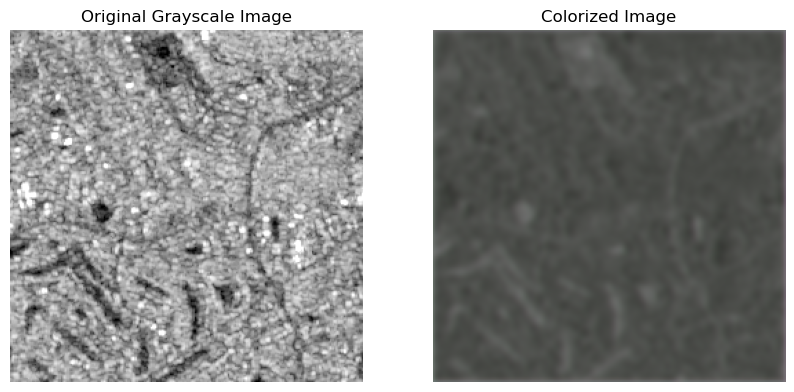

In [25]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def visualize_single_prediction(generator, gray_images):
    # Convert the gray image to uint8 type if necessary
    if gray_images.dtype != np.uint8:
        gray_images = (gray_images * 255).astype(np.uint8)
    
    # Resize the gray image to match the input size expected by the generator
    gray_image_resized = cv2.resize(gray_images, (224, 224))
    gray_image_resized = gray_image_resized / 255.0  # Normalize to [0, 1]
    gray_image_resized = np.expand_dims(gray_image_resized, axis=-1)  # Add channel dimension
    gray_image_resized = np.expand_dims(gray_image_resized, axis=0)  # Add batch dimension

    # Generate colorized image
    colorized_image = generator.predict(gray_image_resized)
    colorized_image = np.squeeze(colorized_image, axis=0)  # Remove batch dimension
    colorized_image = np.clip(colorized_image, 0, 1)  # Ensure values are in the range [0, 1]

    # Display the images
    plt.figure(figsize=(10, 5))

    # Original gray image
    plt.subplot(1, 2, 1)
    plt.imshow(gray_images, cmap='gray')
    plt.title('Original Grayscale Image')
    plt.axis('off')

    # Colorized image
    plt.subplot(1, 2, 2)
    plt.imshow(colorized_image)
    plt.title('Colorized Image')
    plt.axis('off')

    plt.show()

# Assuming gray_images is a single grayscale image
# Directly use gray_images without indexing
visualize_single_prediction(generator, gray_images)
